In [1]:
import numpy as np
import numpy_ml as nml
import numpy_ml.neural_nets as nn
import numpy_ml.neural_nets.optimizers as optim

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import dyn_fed as df
from dyn_fed.metrics import accuracy_scorev2

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi=False
%matplotlib inline

In [2]:
class LogisticReg():
    def __init__(self, optimizer):
        self.flatten = nn.layers.Flatten(optimizer=optimizer)
        self.l1 = nn.layers.FullyConnected(
            10,
            optimizer=optimizer
        )
        self.out = nn.layers.Softmax(optimizer=optimizer)
        
        self.layers = []
        for k, v in self.__dict__.items():
            if isinstance(v, nn.layers.LayerBase):
                self.layers.append(v)
        
    def parameters(self):
        for l in self.layers:
            for k, v in l.parameters.items():
                if v is not None:
                    yield v
        
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self, grads):
        for l in self.layers[::-1]:
            grads = l.backward(grads)
        return grads

In [3]:
class MLP():
    def __init__(self, optimizer):
        self.flatten = nn.layers.Flatten(optimizer=optimizer)
        self.h1 = nn.layers.FullyConnected(
            128,
            act_fn=nn.activations.ReLU(),
            optimizer=optimizer
        )
        self.l1 = nn.layers.FullyConnected(
            10,
            optimizer=optimizer
        )
        self.out = nn.layers.Softmax(optimizer=optimizer)
        
        self.layers = []
        for k, v in self.__dict__.items():
            if isinstance(v, nn.layers.LayerBase):
                self.layers.append(v)
        
    def parameters(self):
        for l in self.layers:
            for k, v in l.parameters.items():
                if v is not None:
                    yield v
        
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self, grads):
        for l in self.layers[::-1]:
            grads = l.backward(grads)
        return grads
    

In [77]:
class SimpleCNN():
    def __init__(self, optimizer):
        self.conv1 = nn.layers.Conv2D(
            6,
            kernel_shape=(3, 3),
            act_fn=nn.activations.ReLU(),
            optimizer=optimizer
        )
        self.max_pool1 = nn.layers.Pool2D(
            kernel_shape=(2, 2),
            stride=2,
            optimizer=optimizer
        )
        
        self.conv2 = nn.layers.Conv2D(
            12,
            kernel_shape=(5, 5),
            act_fn=nn.activations.ReLU(),
            optimizer=optimizer
        )
        self.max_pool2 = nn.layers.Pool2D(
            kernel_shape=(2, 2),
            stride=2,
            optimizer=optimizer
        )
        
        self.flatten = nn.layers.Flatten(optimizer=optimizer)
        
        self.f1 = nn.layers.FullyConnected(
            128,
            act_fn=nn.activations.ReLU(),
            optimizer=optimizer
        )
        self.f2 = nn.layers.FullyConnected(
            60,
            act_fn=nn.activations.ReLU(),
            optimizer=optimizer
        )
        self.f3 = nn.layers.FullyConnected(
            10,
            optimizer=optimizer
        )
        
        self.out = nn.layers.Softmax(optimizer=optimizer)
        
        self.layers = []
        for k, v in self.__dict__.items():
            if isinstance(v, nn.layers.LayerBase):
                self.layers.append(v)
        
    def parameters(self):
        for l in self.layers:
            for k, v in l.parameters.items():
                if v is not None:
                    yield v
        
    def forward(self, x):
        x = self.conv1.forward(x)
        x = self.max_pool1.forward(x)
        x = self.conv2.forward(x)
        x = self.max_pool2.forward(x)
        x = self.flatten.forward(x)
        x = self.f1.forward(x)
        x = self.f2.forward(x)
        x = self.f3.forward(x)
        x = self.out.forward(x)
        return x
    
    def backward(self, grads):
        for l in self.layers[::-1]:
            grads = l.backward(grads)
        return grads

In [83]:
X_train, y_train, X_test, y_test = df.data.mnist.load_data(onehot=True)
X_train = X_train[:, :, :, np.newaxis]

In [84]:
optimizer = optim.optimizers.SGD(lr=0.01, momentum=0.9)
# model = LogisticReg(optimizer)
# model = MLP(optimizer)
model = SimpleCNN(optimizer)
# loss_func = nn.losses.CrossEntropy()
loss_func = nn.losses.CrossEntropy()

In [85]:
X_train.shape

(60000, 28, 28, 1)

In [86]:
batch_size = 64
epochs = 10
train_losses = []
test_losses = []
train_accs = []
test_accs = []

In [87]:
for epoch in tqdm(np.arange(epochs)):
    epoch_loss = 0.0
    n_batches = 0
    for start in tqdm(range(0, X_train.shape[0], batch_size), leave=False):
        end = start + batch_size

        X_batch = X_train[start:end]
        y_batch = y_train[start:end]
        
        for l in model.layers:
            l.flush_gradients()
        
        # Feedforward
        y_pred = model.forward(X_batch)

        # Calculate loss
        batch_loss = loss_func(y_batch, y_pred)

        # Backprop
        grads = loss_func.grad(y_batch, y_pred)
        _ = model.backward(grads)

        # Update gradients
        for i, l in enumerate(model.layers):
            if l.parameters:
                l.parameters['W'] = optimizer(l.parameters['W'], l.gradients['W'], f'W{i}')
                l.parameters['b'] = optimizer(l.parameters['b'], l.gradients['b'], f'b{i}')

        epoch_loss = epoch_loss + batch_loss
        n_batches += 1

    epoch_loss = epoch_loss / n_batches
    
    # Calculate accuracy
    y_pred_train = model.forward(X_train)
    train_acc = accuracy_scorev2(y_train, y_pred_train)
    # test_loss = loss_func(y_test, y_pred_test)
    # Test accuracy
    y_pred_test = model.forward(X_test)
    test_acc = accuracy_scorev2(y_test, y_pred_test)
    test_loss = loss_func(y_test, y_pred_test)
    train_losses.append(epoch_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if epoch % 1 == 0:
        print(
            f"Iteration {epoch}: Loss={epoch_loss:.4f}, test_loss={test_loss:.4f}, "
            f"train accuracy={train_acc:.4f}, test accuracy={test_acc:.4f}"
        )
    epoch += 1

KeyboardInterrupt: 

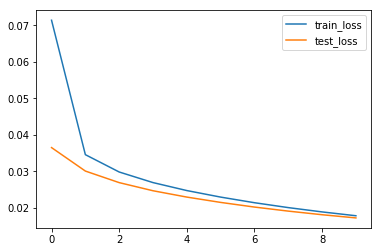

In [50]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend()

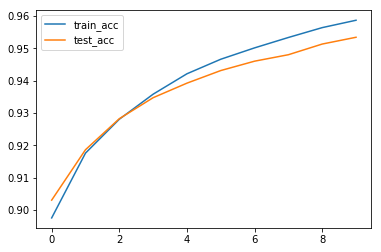

In [51]:
plt.plot(train_accs, label='train_acc')
plt.plot(test_accs, label='test_acc')
plt.legend()

In [186]:
list(model.parameters())

[array([[ 0.0156749 ,  0.0239096 ,  0.02782258, ..., -0.00726044,
          0.02551179, -0.07415281],
        [ 0.05340328, -0.01882841,  0.08417808, ..., -0.0443885 ,
          0.07111691,  0.02089547],
        [-0.08279879,  0.00124917,  0.06329731, ..., -0.00084674,
          0.05999225,  0.01598885],
        ...,
        [-0.02875499, -0.049286  , -0.01312213, ..., -0.05937527,
          0.0441135 ,  0.02890387],
        [-0.05502396, -0.02962902, -0.02599099, ...,  0.02224679,
          0.07484099, -0.07663507],
        [-0.04506697, -0.04304182,  0.01417841, ...,  0.03020654,
          0.01102094, -0.06458024]]),
 array([[-0.33707781,  0.179214  ,  0.06515067, -0.27878068,  0.04001873,
          1.14832942,  0.02781151,  0.54668659, -1.17241796, -0.21893449]])]